<h4>1 - Install the required libraries</h4>
~<code>pip install flask flask_cors pandas seaborn sklearn openpyxl</code>

In [31]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from sklearn import metrics
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
import pickle

<h4>2 - Read Training Data</h4>

In [32]:
train_data = pd.read_excel('Flight-Dataset/Data_Train.xlsx')
train_data.dropna(inplace=True)
train_data.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


<h4>3 - Checking values in the Destination column</h4>
This shows that the maximum people are going to Cochin followed by Banglore and then Delhi in the dataset.

In [33]:
train_data['Destination'].value_counts()

Cochin       4536
Banglore     2871
Delhi        1265
New Delhi     932
Hyderabad     697
Kolkata       381
Name: Destination, dtype: int64

Merging Delhi and New Delhi.

In [34]:
def newd(x):
    if x=='New Delhi':
        return 'Delhi'
    else:
        return x
train_data['Destination'] = train_data['Destination'].apply(newd)

<h4>4 - Data preprocessing</h4>
<ul>
  <li>Drop <code>Route</code> and <code>Additional_Info</code> columns.</li>
  <li>We extract the journey day and journey month from the <code>Date_of_Journey</code> and create new columns <code>Journey_day</code> and <code>Journey_month</code>. We drop <code>Date_of_Journey</code> column.</li>
  <li>We extract the departure hour and departure min from the <code>Dep_Time</code> and create new columns <code>Dep_hour</code> and <code>Dep_min</code>. We drop <code>Dep_Time</code> column.</li>
  <li>We extract the arrival hour and arrival min from the <code>Arrival_Time</code> and create new columns <code>Arrival_hour</code> and <code>Arrival_min</code>. We drop <code>Arrival_Time</code> column.</li>
  <li>We extract the duration hour and duration min from the <code>Duration</code> and create new columns <code>Duration_hours</code> and <code>Duration_mins</code>. We drop <code>Duration</code> column.</li>
</ul>

In [35]:
# Route and Additional_Info
train_data.drop(['Route','Additional_Info'], inplace=True, axis=1)

# Journey Date
train_data['Journey_day'] = pd.to_datetime(train_data['Date_of_Journey'], format='%d/%m/%Y').dt.day
train_data['Journey_month'] = pd.to_datetime(train_data['Date_of_Journey'], format='%d/%m/%Y').dt.month
train_data.drop('Date_of_Journey', inplace=True, axis=1)

# Departure Time
train_data['Dep_hour'] = pd.to_datetime(train_data['Dep_Time']).dt.hour
train_data['Dep_min'] = pd.to_datetime(train_data['Dep_Time']).dt.minute
train_data.drop('Dep_Time', axis=1, inplace=True)

# Arrival Time
train_data['Arrival_hour'] = pd.to_datetime(train_data['Arrival_Time']).dt.hour
train_data['Arrival_min'] = pd.to_datetime(train_data['Arrival_Time']).dt.minute
train_data.drop('Arrival_Time', axis=1,inplace=True)

# Duration
duration = list(train_data['Duration'])
for i in range(len(duration)):
    if len(duration[i].split()) != 2:
        if 'h' in duration[i]:
            duration[i] = duration[i] + ' 0m'
        else:
            duration[i] = '0h ' + duration[i]
duration_hour = []
duration_min = []
for i in duration:
    h,m = i.split()
    duration_hour.append(int(h[:-1]))
    duration_min.append(int(m[:-1]))
train_data['Duration_hours'] = duration_hour
train_data['Duration_mins'] = duration_min
train_data.drop('Duration',axis=1,inplace=True)

train_data.head()

,Airline,Source,Destination,Total_Stops,Price,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,Duration_mins
0,IndiGo,Banglore,Delhi,non-stop,3897,24,3,22,20,1,10,2,50
1,Air India,Kolkata,Banglore,2 stops,7662,1,5,5,50,13,15,7,25
2,Jet Airways,Delhi,Cochin,2 stops,13882,9,6,9,25,4,25,19,0
3,IndiGo,Kolkata,Banglore,1 stop,6218,12,5,18,5,23,30,5,25
4,IndiGo,Banglore,Delhi,1 stop,13302,1,3,16,50,21,35,4,45


<h4>5 - Plotting Airline vs Price.</h4>
We use <a href="https://seaborn.pydata.org/generated/seaborn.catplot.html"><code>sns.catplot</code></a> to plot the Airline vs Price.
<ul><a href="https://seaborn.pydata.org/generated/seaborn.catplot.html"><code>sns.catplot</code></a>
  <li><code>x,y</code>: Names of variables in <code>data</code></li>
  <li><code>data</code>: Dataframe used for plotting. Each column should correspond to a variable, and each row should correspond to an observation.</li>
  <li><code>kind</code>: The kind of plot to draw, corresponds to the name of a categorical axes-level plotting function.</li>
  <li><code>aspect</code>: Aspect ratio of each facet, so that aspect * height gives the width of each facet in inches.</li>
  <li><code>height</code>: Height (in inches) of each facet.</li>
</ul>
It seems Jet Airways business is the costliest airways.

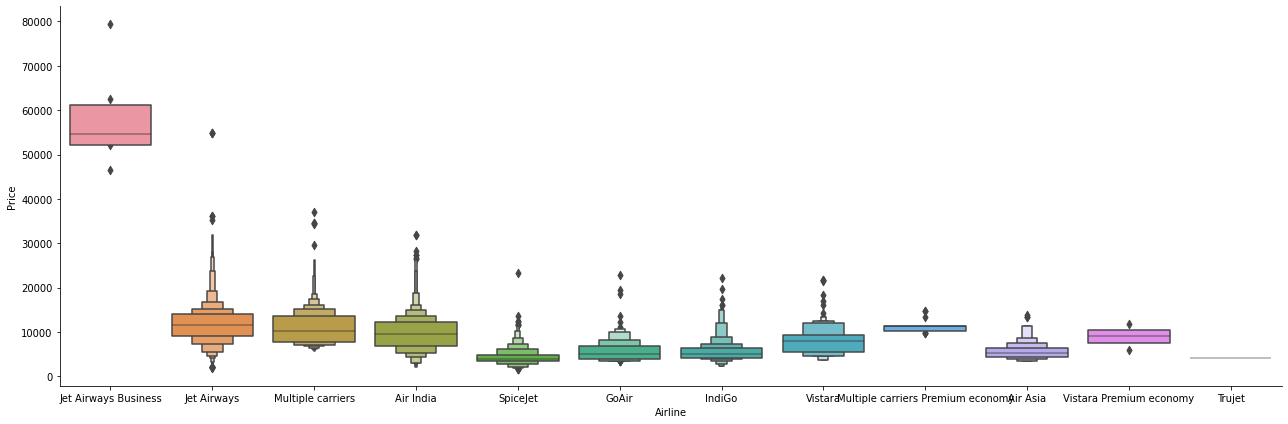

In [36]:
sns.catplot(
  x='Airline',
  y='Price',
  data=train_data.sort_values('Price',ascending=False),
  kind='boxen',
  aspect=3,
  height=6
  )

<h4>6 - Plotting Source vs Price</h4>
We use <a href="https://seaborn.pydata.org/generated/seaborn.catplot.html"><code>sns.catplot</code></a> to plot the Source vs Price.
<ul><a href="https://seaborn.pydata.org/generated/seaborn.catplot.html"><code>sns.catplot</code></a>
  <li><code>x,y</code>: Names of variables in <code>data</code></li>
  <li><code>data</code>: Dataframe used for plotting. Each column should correspond to a variable, and each row should correspond to an observation.</li>
  <li><code>kind</code>: The kind of plot to draw, corresponds to the name of a categorical axes-level plotting function.</li>
  <li><code>aspect</code>: Aspect ratio of each facet, so that aspect * height gives the width of each facet in inches.</li>
  <li><code>height</code>: Height (in inches) of each facet.</li>
</ul>
It seems if your source is Bangalore, no matter where you're going you have to pay the highest amount of money.

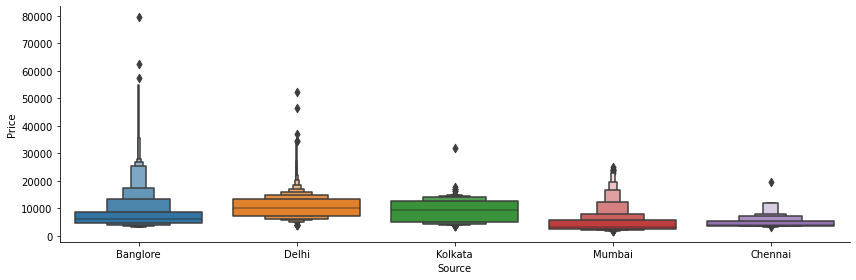

In [37]:
# If we are going from Banglore the prices are slightly higher as compared to other cities
sns.catplot(
  x='Source',
  y='Price',
  data=train_data.sort_values('Price',ascending=False),
  kind='boxen',
  aspect=3,
  height=4
  )

<h4>7 - Plotting Destination vs Price.</h4>
We use <a href="https://seaborn.pydata.org/generated/seaborn.catplot.html"><code>sns.catplot</code></a> to plot the Destination vs Price.
<ul><a href="https://seaborn.pydata.org/generated/seaborn.catplot.html"><code>sns.catplot</code></a>
  <li><code>x,y</code>: Names of variables in <code>data</code></li>
  <li><code>data</code>: Dataframe used for plotting. Each column should correspond to a variable, and each row should correspond to an observation.</li>
  <li><code>kind</code>: The kind of plot to draw, corresponds to the name of a categorical axes-level plotting function.</li>
  <li><code>aspect</code>: Aspect ratio of each facet, so that aspect * height gives the width of each facet in inches.</li>
  <li><code>height</code>: Height (in inches) of each facet.</li>
</ul>
It seems no matter the source, if your destination is New Dehli, you have to pay the highet amount of money.

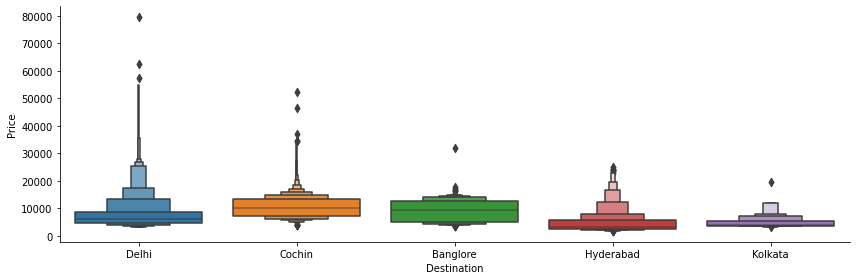

In [38]:
sns.catplot(
  x='Destination',
  y='Price',
  data=train_data.sort_values('Price',
  ascending=False),
  kind='boxen',
  aspect=3,
  height=4
  )

<h4>8 - Create dummy columns out of the <code>Airline</code>, <code>Source</code> and <code>Destination</code> columns.</h4>
<a href="https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html"><code>pandas.get_dummies</code></a> converts categorical variable into dummy/indicator variables.

In [39]:
airline = train_data[['Airline']]
airline = pd.get_dummies(airline, drop_first=True)

source = train_data[['Source']]
source = pd.get_dummies(source, drop_first=True)

destination = train_data[['Destination']]
destination = pd.get_dummies(destination, drop_first=True)

In [40]:
source.head()

,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai
0,0,0,0,0
1,0,0,1,0
2,0,1,0,0
3,0,0,1,0
4,0,0,0,0


In [41]:
destination.head()

,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata
0,0,1,0,0
1,0,0,0,0
2,1,0,0,0
3,0,0,0,0
4,0,1,0,0


<h4>9 - Converting labels into numbers in the Total_stops column.</h4>
According to the data, price is directly proportional to the number of stops.

In [42]:
totalStopDictConv = {
  'non-stop': 0,
  '1 stop': 1,
  '2 stops': 2,
  '3 stops': 3,
  '4 stops': 4
}

# Total Stops
train_data['Total_Stops'].replace(totalStopDictConv, inplace=True)
train_data.head()

,Airline,Source,Destination,Total_Stops,Price,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,Duration_mins
0,IndiGo,Banglore,Delhi,0,3897,24,3,22,20,1,10,2,50
1,Air India,Kolkata,Banglore,2,7662,1,5,5,50,13,15,7,25
2,Jet Airways,Delhi,Cochin,2,13882,9,6,9,25,4,25,19,0
3,IndiGo,Kolkata,Banglore,1,6218,12,5,18,5,23,30,5,25
4,IndiGo,Banglore,Delhi,1,13302,1,3,16,50,21,35,4,45


<h4>10 - Checking the shapes of our 4 data frames.</h4>


In [43]:
print(f"airline.shape: {airline.shape}")
print(f"source.shape: {source.shape}")
print(f"destination.shape: {destination.shape}")
print(f"train_data.shape: {train_data.shape}")

airline.shape: (10682, 11)
source.shape: (10682, 4)
destination.shape: (10682, 4)
train_data.shape: (10682, 13)


<h4>11 - Combine all 4 data frames</h4>
Join all 4 data frames. Drop the Airline, Source, and, Destination columns.

In [44]:
data_train = pd.concat([train_data, airline, source, destination], axis=1)
data_train.drop(['Airline', 'Source', 'Destination'], axis=1, inplace=True)
data_train.head()

,Total_Stops,Price,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,Duration_mins,...,Airline_Vistara,Airline_Vistara Premium economy,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata
0,0,3897,24,3,22,20,1,10,2,50,...,0,0,0,0,0,0,0,1,0,0
1,2,7662,1,5,5,50,13,15,7,25,...,0,0,0,0,1,0,0,0,0,0
2,2,13882,9,6,9,25,4,25,19,0,...,0,0,0,1,0,0,1,0,0,0
3,1,6218,12,5,18,5,23,30,5,25,...,0,0,0,0,1,0,0,0,0,0
4,1,13302,1,3,16,50,21,35,4,45,...,0,0,0,0,0,0,0,1,0,0


<h4>12 - Taking out training and target data</h4>
<ul>
  <li><code>X</code> will be our training data which is the <code>data_train</code> without the <code>Price</code> column. </li>
  <li><code>Y</code> will be our target data which will be the <code>Price</code> column.</li>
</ul>



In [45]:
X = data_train.drop('Price', axis=1)
X.head()

,Total_Stops,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,Duration_mins,Airline_Air India,...,Airline_Vistara,Airline_Vistara Premium economy,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata
0,0,24,3,22,20,1,10,2,50,0,...,0,0,0,0,0,0,0,1,0,0
1,2,1,5,5,50,13,15,7,25,1,...,0,0,0,0,1,0,0,0,0,0
2,2,9,6,9,25,4,25,19,0,0,...,0,0,0,1,0,0,1,0,0,0
3,1,12,5,18,5,23,30,5,25,0,...,0,0,0,0,1,0,0,0,0,0
4,1,1,3,16,50,21,35,4,45,0,...,0,0,0,0,0,0,0,1,0,0


In [46]:
y = data_train['Price']
y.head()

0     3897
1     7662
2    13882
3     6218
4    13302
Name: Price, dtype: int64

<h4>13 - Feature Selection</h4>
Finding out the best feature which will contribute and have good relation with target variable. Following are some of the feature selection methods
<ul>
  <li>heatmap</li>
  <li>feature_importance_</li>
</ul>

<h4>13a - Heatmap - Checking correlations between columns.</h4>
<ul><a href="https://seaborn.pydata.org/generated/seaborn.heatmap.html"><code>seaborn.heatmap</code></a>
  <li><code>data</code>: 2D dataset that can be coerced into an ndarray. If a Pandas DataFrame is provided, the index/column information will be used to label the columns and rows. <code>.corr</code> computes pairwise correlation of columns, excluding NA/null values.</li>
  <li><code>cmap</code>: The mapping from data values to color space. If not provided, the default will depend on whether center is set.</li>
  <li><code>annot</code>: If True, write the data value in each cell. If an array-like with the same shape as data, then use this to annotate the heatmap instead of the data. Note that DataFrames will match on position, not index.</li>
</ul>

We can see that <code>Total_stops</code> is highly correlated with Duration_hours which is very obvious. If the no. of stops would increase, the duration hours of the flight will also increase.
We can see that <code>Price</code> is highly correlated with total stops because if stops would increase that would also require a high quantity of fuel, and that would increase the price.

<AxesSubplot: >

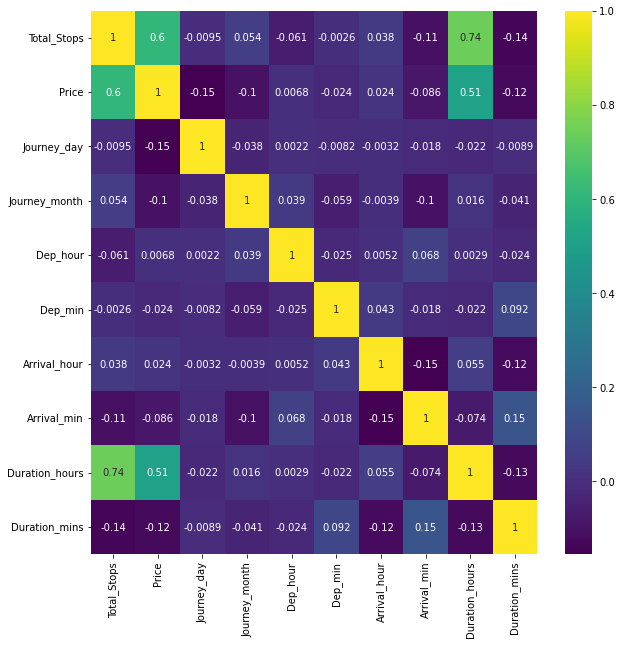

In [47]:
plt.figure(figsize=(10,10))
sns.heatmap(
    data = train_data.corr(numeric_only=True), 
    cmap = 'viridis', 
    annot = True)

<h4>13b - feature_importance_</h4>
We fit our data into <a href="https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesRegressor.html"><code>ExtraTreesRegressor</code></a> and analyze the feature importances.
<ul>
  <li>The sklearn.ensemble module includes two averaging algorithms based on randomized decision trees: the RandomForest algorithm and the Extra-Trees method. This means a diverse set of classifiers is created by introducing randomness in the classifier construction. The prediction of the ensemble is given as the averaged prediction of the individual classifiers.</li>
  <li>The <code>ExtraTreesRegressor</code> class implements a meta estimator that fits a number of randomized decision trees (a.k.a. extra-trees) on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.</li>
</ul>

In [48]:
reg = ExtraTreesRegressor()
reg.fit(X,y)
print(reg.feature_importances_)

[2.52649927e-01 1.43405353e-01 5.82969770e-02 2.43040057e-02
 2.11602098e-02 2.80055684e-02 1.89366480e-02 1.05641389e-01
 1.77051466e-02 9.46938276e-03 1.67988998e-03 1.73459613e-02
 1.41874387e-01 6.72190515e-02 1.99912842e-02 8.88554965e-04
 5.00780956e-03 9.28557219e-05 4.83797780e-03 8.19747591e-05
 8.60071307e-04 1.29291260e-02 5.01227326e-03 9.78690724e-03
 7.02727208e-03 1.81142272e-02 7.08213889e-03 5.93630785e-04]


Checking feature importance given by <code>ExtraTreesRegressor</code>.<br>
Total_stops is the feature with the highest feature importance in deciding the Price as we have also seen above.
After that Journey Day also plays a big role in deciding the Price. Prices are generally higher on weekends.

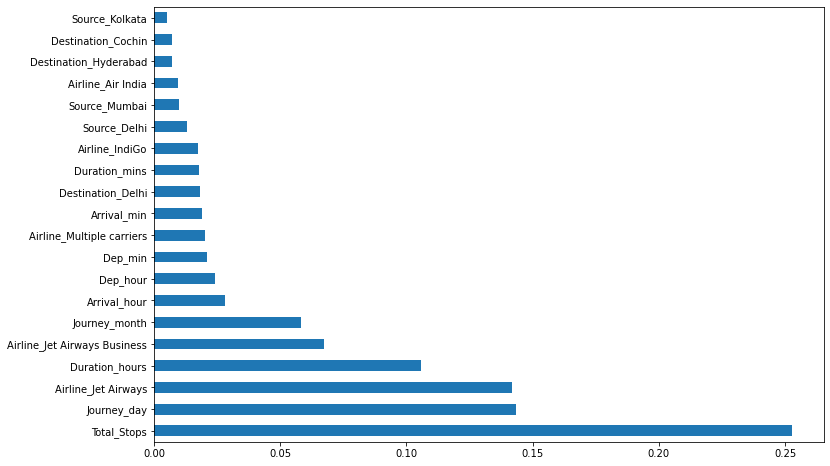

In [49]:
plt.figure(figsize = (12,8))
feat_importances = pd.Series(reg.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()

<h4>14 - Splitting our data into Training and Testing data</h4>

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

<h4>15 - Training Random Forest Regressor model for Flight Price Prediction</h4>
<ul><a href="https://numpy.org/doc/stable/reference/generated/numpy.linspace.html"><code>numpy.linspace</code></a>
  <li><code>start</code>: The starting value of the sequence.</li>
  <li><code>stop</code>: The end value of the sequence</li>
  <li><code>num</code>: Number of samples to generate. Default is 50.</li>
</ul>
<ul><a href="https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html"><code>sklearn.model_selection.RandomizedSearchCV</code></a>
  <li><code>estimator</code>: An object of that type is instantiated for each grid point. This is assumed to implement the scikit-learn estimator interface. Either estimator needs to provide a score function, or scoring must be passed.</li>
  <li><code>param_distributions</code>: Dictionary with parameters names (str) as keys and distributions or lists of parameters to try.</li>
  <li><code>scoring</code>: Strategy to evaluate the performance of the cross-validated model on the test set.</li>
  <li><code>n_iter</code>: Number of parameter settings that are sampled. n_iter trades off runtime vs quality of the solution.</li>
  <li><code>cv</code>: Determines the cross-validation splitting strategy. Integer to specify the number of folds in a (Stratified)KFold</li>
  <li><code>verbose</code>: Controls the verbosity: the higher, the more messages.</li>
  <li><code>random_state</code>: Pseudo random number generator state used for random uniform sampling from lists of possible values instead of scipy.stats distributions. Pass an int for reproducible output across multiple function calls.</li>
  <li><code>n_jobs</code>: Number of jobs to run in parallel.</li>
</ul>
Here we are using <code>RandomizedSearchCV</code> which just randomly tries out combinations and sees which one is the best out of them. We have declared the parameters of <code>RandomForestRegressor</code> which we want to try.

In [51]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1200, num = 12)]

# Number of features to consider at every split
max_features = ['sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 30, num = 6)]

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15, 100]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 5, 10]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}


# Random search of parameters, using 5 fold cross validation, search across 100 different combinations
rf_random = RandomizedSearchCV(estimator = RandomForestRegressor(), 
                               param_distributions = random_grid,
                               scoring='neg_mean_squared_error', 
                               n_iter = 10, 
                               cv = 5, 
                               verbose=1, 
                               random_state=42, 
                               n_jobs = 1)
rf_random.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=1,
                   param_distributions={'max_depth': [5, 10, 15, 20, 25, 30],
                                        'max_features': ['sqrt'],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 10, 15,
                                                              100],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000, 1100,
                                                         1200]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=1)

<h4>16 - Checking the best parameters we got using Randomized Search CV</h4>

In [52]:
rf_random.best_params_

{'n_estimators': 300,
 'min_samples_split': 15,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 30}

<h4>17 - Taking Predictions</h4>

In [53]:
# Flight Price Prediction
prediction = rf_random.predict(X_test)

<h4>18 - Plotting the residuals</h4>
As we can see that most of the residuals are 0, which means our model is generalizing well.

<Figure size 576x576 with 0 Axes>

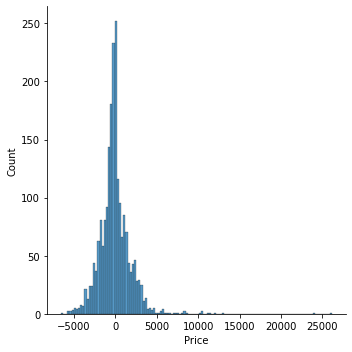

In [54]:
plt.figure(figsize = (8,8))
sns.displot(y_test-prediction)
plt.show()

<h4>19 - Plotting y_test vs predictions</h4>
Ideally, it should be a straight line.

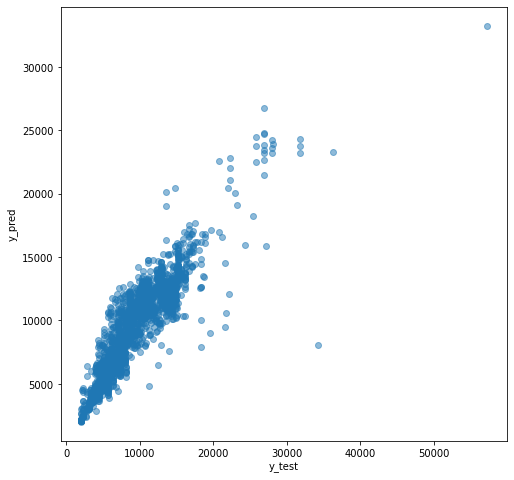

In [55]:
plt.figure(figsize = (8,8))
plt.scatter(y_test, prediction, alpha = 0.5)
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.show()

<h4>20 - Printing metrics</h4>

In [56]:
print('r2 score: ', metrics.r2_score(y_test, prediction))

r2 score:  0.8178400025146358


<h4>21 - Saving our model</h4>


In [57]:
file = open('flight_rf.pkl', 'wb')
pickle.dump(rf_random, file)